# dewey 10진 분류로 재카테고리화

- 수행 이유
    - mission 전처리된 카테고리보다 더 체계화된 카테고리를 찾기 위함
    - `가정: 유명한 분류법을 사용하면 책의 카테고리를 더 잘 나눌 수 있지 않을까?`
- 수행 방식
    - dewey 000, 100, ..., 900 번대 각각의 sub-category를 list 로 구성
    - 총 10개의 카테고리로 재분류
    - 기본적인 전처리 후, 동일한 book_title과 publisher 일 경우 최빈값으로 카테고리 imputation 
- 결과 요약
    - 오히려 dewey 방식 사용시 성능이 저하됨
    - 또한 카테고리가 제대로 나누어지지 않아 imputation도 제대로 안됨
    - 기정님 카테고리 재그룹화 방식을 선택하자

## 0. 데이터 로드

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
base_path = os.path.join(os.curdir, 'data')
book_path = os.path.join(base_path, 'books.csv')
books = pd.read_csv(book_path, encoding='utf-8')

In [3]:
# book shape 확인
books.shape

(149570, 10)

In [4]:
print('isbn 개수: ', books['isbn'].nunique())               # isbn은 다 다름
print('book_title 개수: ', books['book_title'].nunique())   # 동일한 책 제목 있음

isbn 개수:  149570
book_title 개수:  135436


In [5]:
# 초기 nan 확인
books.isna().sum()

isbn                       0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
img_url                    0
language               67227
category               68851
summary                67227
img_path                   0
dtype: int64

## 1. publisher 재그룹화

In [6]:
# publisher 당 데이터 수 count 
publisher_dict = (books['publisher'].value_counts()).to_dict()
publisher_count_df = pd.DataFrame(list(publisher_dict.items()), columns=['publisher', 'count'])
publisher_count_df = publisher_count_df.sort_values(by=['count'], ascending=False)

In [7]:
# top5 publisher 확인
publisher_count_df.head()

,publisher,count
0,Harlequin,3005
1,Ballantine Books,2322
2,Pocket,2274
3,Penguin Books,1943
4,Bantam Books,1938


In [8]:
# 전처리 전 publisher 수 
books['publisher'].nunique()

11571

In [9]:
# isbn 앞 4자리를 통해 publisher 추정 
modify_list = publisher_count_df[publisher_count_df['count']>1].publisher.values
for publisher in modify_list:
    try:
        number = books[books['publisher']==publisher]['isbn'].apply(lambda x: x[:4]).value_counts().index[0]
        right_publisher = books[books['isbn'].apply(lambda x: x[:4])==number]['publisher'].value_counts().index[0]
        books.loc[books[books['isbn'].apply(lambda x: x[:4])==number].index,'publisher'] = right_publisher
    except: 
        pass

In [10]:
# 전처리 후 publisher 수
books['publisher'].nunique()

1523

In [11]:
# 책이 한 권인 출판사도 있음
books['publisher'].value_counts()

Pocket                        7306
Harlequin                     5268
Bantam Books                  4815
St. Martin's Press            4043
Vintage Books USA             3822
                              ... 
Oh Editions                      1
Saur                             1
Rossmen                          1
Tascabili Economici Newton       1
Information                      1
Name: publisher, Length: 1523, dtype: int64

## 2. category 재그룹화

In [12]:
# category가 있는 경우의 category 확인 (여러개 있나)
books[books['category'].notnull()]['category'].head()

0    ['Actresses']
1    ['1940-1949']
2      ['Medical']
3      ['Fiction']
4      ['History']
Name: category, dtype: object

In [13]:
# str으로 바꾸기
import re
books.loc[books[books['category'].notnull()].index, 'category'] = books[books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())

In [14]:
# 소문자로 바꾼 후 category 당 count 확인
books['category'] = books['category'].str.lower()
books['category'].value_counts() 

fiction                                            33016
juvenile fiction                                    5835
biography autobiography                             3326
history                                             1927
religion                                            1818
                                                   ...  
brenner simon fictitious character                     1
gone with the wind motion picture 1939                 1
disguise                                               1
country lawyers                                        1
authors canadian english 20th century biography        1
Name: category, Length: 4105, dtype: int64

In [15]:
# category 종류 - count dataframe 만들기
category_df = pd.DataFrame(books['category'].value_counts()).reset_index()
category_df.columns = ['category', 'count']
# top10 category 확인
category_df.head(10)

,category,count
0,fiction,33016
1,juvenile fiction,5835
2,biography autobiography,3326
3,history,1927
4,religion,1818
5,juvenile nonfiction,1418
6,social science,1231
7,humor,1161
8,body mind spirit,1113
9,business economics,1073


In [16]:
more_50 = category_df[category_df['count'] > 50]
more_50.tail(30)

,category,count
45,adventure stories,132
46,games activities,128
47,games,125
48,architecture,116
49,american fiction,116
50,law,104
51,antiques collectibles,97
52,english fiction,93
53,friendship,84
54,brothers and sisters,84


In [17]:
# category 확인용 
category_df[category_df['category'].str.contains('histori')
# & category_df['category'].str.contains('religion') 
# & ~(category_df['category'].str.contains(' s'))
].head(20)

,category,count
156,historical fiction,17
609,antiquities prehistoric,4
879,chronology historical,3
1221,historians,2
1440,historic sites,2
1517,historiography,2
1550,imaginary histories,2
1872,alternative histories fiction,1
1875,art historians,1
1924,alternative histories,1


### dewey category (10진 분류)

`가정: 유명한 분류법을 사용하면 재카테고리화가 쉽지 않을까?`
- 테스트 용 demo data
- dewey category 로 대략적으로 나눠보았으나, 같은 100번대에 있어도 다양한 분야가 있어서 dewey 10진 분류는 적절하지 않아보임. 실제로 성능도 더 안좋아짐
- 문제점을 인식하고 **결국 카테고리 재분류는 기정님 데이터 사용**

In [18]:
# Dewey Decimal Classification chart 참고
# value 리스트에 포함된 단어로 category 재분류 (10개로 줄이기)
dewey_categories = [
    ['computer', 'bibl', 'encyclopedia', 'journal', 'magazine', 'association', 'museum', 'media', 'quot', 'general'],
    ['metaphysics', 'causation', 'psychology', 'occultism', 'logic', 'philosophy'],
    ['bibl', 'christian', 'worship', 'religion'],
    ['anthropolo', 'commerce', 'custom', 'etiquette', 'education', 'folklore' 'social science'],
    ['language'],
    ['mathemat', 'astro', 'physic', 'chemi', 'earth', 'geography', 'geology', 'fossil', 'prehistor', 'biolog', 'plant', 'botany', 'animal', 'zoo', 'cat', 'dog', 'science'],
    ['medicine', 'health', 'engineering', 'agriculture', 'management', 'technology'],
    ['landscap', 'architect', 'house home', 'ceramic', 'drawing', 'paint', 'photo', 'music' 'decorat', 'craft', 'sport', 'game', 'art ', ' art'], # 정확히 art 인것만 추가 
    ['novel', 'stories', 'fiction', 'literary', 'literature'],
    ['geograph', 'travel', 'history']
]

In [19]:
for category in dewey_categories:
    for i in category:
        books.loc[books[books['category'].str.contains(i,na=False)].index,'dewey_category'] = category[-1]


In [20]:
books.isna().sum()

isbn                       0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
img_url                    0
language               67227
category               68851
summary                67227
img_path                   0
dewey_category         91441
dtype: int64

## Imputation

### 책 제목으로 카테고리 채워넣기

`가정: 책 제목과 카테고리가 관계 있지 않을까?`
- 이것도 테스트용 demo data
- 카테고리 결측치를 채우기 위한 시험일 뿐 (완성본 X)

In [21]:
# book_title - count DataFrame
book_title_df = pd.DataFrame(books['book_title'].value_counts()).reset_index()
book_title_df.columns = ['book_title', 'count']
book_title_df[book_title_df['count']>1].head(20)

,book_title,count
0,The Secret Garden,18
1,Selected Poems,16
2,Adventures of Huckleberry Finn,15
3,Dracula,15
4,Beloved,14
5,Wuthering Heights,14
6,Pride and Prejudice,14
7,Little Women,14
8,Jane Eyre,14
9,The Hobbit,12


In [23]:
# 동일한 책 제목 확인 
same_title_book = book_title_df[book_title_df['count']>1]['book_title'].values.tolist()

In [24]:
books.loc[books[books['book_title'].isin(same_title_book)].index, :].isna().sum()

isbn                       0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
img_url                    0
language               10637
category               10840
summary                10637
img_path                   0
dewey_category         13735
dtype: int64

In [27]:
# 최빈값으로 category 채우기 
for title in same_title_book:
    same_title = books['book_title'] == title
    if books.loc[same_title, 'dewey_category'].isnull().all():
        continue
    else:
        category_mode = books.loc[same_title, 'dewey_category'].mode()[0]
        books.loc[same_title, 'dewey_category'] = books.loc[same_title, 'dewey_category'].fillna(category_mode)

In [28]:
books[books['book_title'] == "Masquerade"].head(10)

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,dewey_category
9021,042516019X,Masquerade,Gayle Lynds,1997.0,Berkley Publishing Group,http://images.amazon.com/images/P/042516019X.0...,en,fiction,"The victim of amnesia, a government agent must...",images/042516019X.01.THUMBZZZ.jpg,literature
32316,080523747X,Masquerade,Kit Williams,1984.0,Henry Holt & Company,http://images.amazon.com/images/P/080523747X.0...,en,children s stories english,On his way to deliver a splendid necklace to t...,images/080523747X.01.THUMBZZZ.jpg,literature
33293,0821728334,Masquerade,Lowell Cauffiel,1989.0,Zebra Books,http://images.amazon.com/images/P/0821728334.0...,NaN,fiction,NaN,images/0821728334.01.THUMBZZZ.jpg,literature
39753,0897330137,Masquerade,Sarah Hobson,1982.0,Academy Chicago Publishers,http://images.amazon.com/images/P/0897330137.0...,en,travel,"Traveling in Iran dressed as a boy, Hobson rel...",images/0897330137.01.THUMBZZZ.jpg,history
42124,0425117405,Masquerade,Serena Richards,1989.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425117405.0...,en,fiction,Armande de LeCroix lives strictly by the sword...,images/0425117405.01.THUMBZZZ.jpg,literature
44070,0345366204,Masquerade,William X. Kienzle,1991.0,Ballantine Books,http://images.amazon.com/images/P/0345366204.0...,en,fiction,A mystery writers&#39; conference gets a dose ...,images/0345366204.01.THUMBZZZ.jpg,literature
44907,0786015047,Masquerade,Lowell Cauffiel,2001.0,Hyperion,http://images.amazon.com/images/P/0786015047.0...,en,true crime,This true crime account unravels the bizarre c...,images/0786015047.01.THUMBZZZ.jpg,literature
89840,0385479611,Masquerade,Gayle Lynds,1996.0,Bantam Dell Pub Group,http://images.amazon.com/images/P/0385479611.0...,en,fiction,"Confused, dazed, and unable to remember her ow...",images/0385479611.01.THUMBZZZ.jpg,literature
96287,0312969899,Masquerade,Walter Satterthwait,1999.0,St. Martin's Press,http://images.amazon.com/images/P/0312969899.0...,en,fiction,"In the sequel to Escapade, Jane and Phil unwit...",images/0312969899.01.THUMBZZZ.jpg,literature
116644,0451407016,Masquerade,Mary Kingsley,1997.0,Signet Book,http://images.amazon.com/images/P/0451407016.0...,en,fiction,An exchange of glances with a condemned man ab...,images/0451407016.01.THUMBZZZ.jpg,literature


In [29]:
books.isna().sum()

isbn                       0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
img_url                    0
language               67227
category               64740
summary                67227
img_path                   0
dewey_category         84839
dtype: int64

### 출판사로 카테고리 채워넣기

`가정: 출판사와 카테고리가 관계 있지 않을까? 출판사마다 주 카테고리가 있지 않을까?`
- 이것도 테스트용 demo data
- 카테고리 결측치를 채우기 위한 시험일 뿐 (완성본 X)

In [30]:
# 출판사 - count DataFrame
book_publisher_df = pd.DataFrame(books['publisher'].value_counts()).reset_index()
book_publisher_df.columns = ['publisher', 'count']

In [31]:
same_publisher_book = book_publisher_df[book_publisher_df['count']>1]['publisher'].values.tolist()

In [32]:
# 통계 확인
books[books['publisher'] == "Pocket"]['category'].describe(include='all')

count        4409
unique        442
top       fiction
freq         2368
Name: category, dtype: object

In [33]:
# 책 이름 - count DataFrame
book_title_df = pd.DataFrame(books['book_title'].value_counts()).reset_index()
book_title_df.columns = ['book_title', 'count']

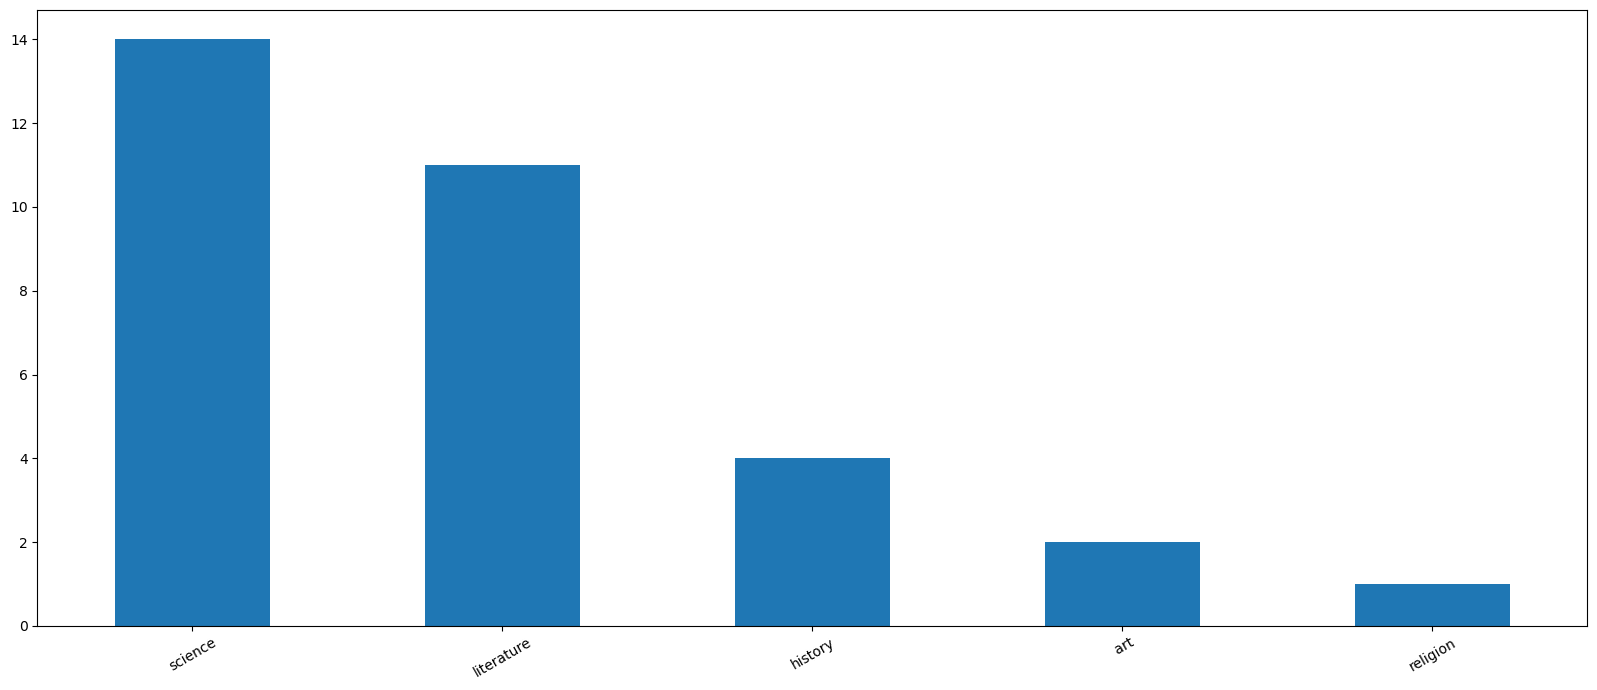

In [36]:
# 유명 출판사 외의 category 분포 파악 
plt.figure(figsize=(20, 8))
x = books[books['publisher'] == "Columbia University Press"]['dewey_category'].value_counts().sort_values(ascending=False)[:10]
x.plot(kind='bar')
plt.xticks(rotation=30)
plt.show()

In [37]:
books[books['publisher'] == "Columbia University Press"]
# 오 생각보다 너무 다르게 imputation 됨 -> dewey 버리고 기정님 방식 사용하자

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,dewey_category
1897,0231105592,The Garden of Ediacara,Mark A. S. McMenamin,2000.0,Columbia University Press,http://images.amazon.com/images/P/0231105592.0...,en,science,Including twenty-two photographs and more than...,images/0231105592.01.THUMBZZZ.jpg,science
6779,0231121008,The Vital Illusion,Jean Baudrillard,2001.0,Columbia University Press,http://images.amazon.com/images/P/0231121008.0...,en,literary criticism,The sociologist Jean Baudrillard grapples with...,images/0231121008.01.THUMBZZZ.jpg,literature
8734,0231120621,Invisible Light,Diana Culbertson,2000.0,Columbia University Press,http://images.amazon.com/images/P/0231120621.0...,en,poetry,This collection of poems is a small contributi...,images/0231120621.01.THUMBZZZ.jpg,NaN
30477,023108028X,The Top 500 Poems,William Harmon,1992.0,Columbia University Press,http://images.amazon.com/images/P/023108028X.0...,en,poetry,"Poems by Chaucer, Shakespeare, Wordsworth, Dic...",images/023108028X.01.THUMBZZZ.jpg,NaN
35566,0231042116,The Creation of Tomorrow: Fifty Years of Magaz...,Paul Allen Carter,1980.0,Columbia University Press,http://images.amazon.com/images/P/0231042116.0...,NaN,NaN,NaN,images/0231042116.01.THUMBZZZ.jpg,NaN
38225,0231102976,The Anarchical Society,Hedley Bull,1995.0,Columbia University Press,http://images.amazon.com/images/P/0231102976.0...,en,diplomacy,On international relations Where traditional s...,images/0231102976.01.THUMBZZZ.jpg,NaN
38719,0231124244,T. S. Eliot: The Waste Land,Nick Selby,2001.0,Columbia University Press,http://images.amazon.com/images/P/0231124244.0...,en,literary criticism,"Selby (American studies, U. of Wales, Swansea)...",images/0231124244.01.THUMBZZZ.jpg,literature
57764,0231129505,Autobiography of a Geisha,Sayo Masuda,2003.0,Columbia University Press,http://images.amazon.com/images/P/0231129505.0...,en,biography autobiography,First-person account of the life of a geisha i...,images/0231129505.01.THUMBZZZ.jpg,NaN
66496,0231069170,School of the Sun (Twentieth-Century Continent...,Ana Maria Matute,1989.0,Columbia University Press,http://images.amazon.com/images/P/0231069170.0...,en,fiction,A Spanish writer&#39;s approach by the intimis...,images/0231069170.01.THUMBZZZ.jpg,literature
73583,0231066473,The Emergence of Animals,Mark A. S. McMenamin,1990.0,Columbia University Press,http://images.amazon.com/images/P/0231066473.0...,en,science,The authors explore the late Precambrian and e...,images/0231066473.01.THUMBZZZ.jpg,science
